In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import arviz as az
from makeCorner import *
import sys
sys.path.append("./../code/")
from piCurve import *
from load_data import *

For this run, we assume that the stochastic gravitational-wave background is unpolarized (equal amounts in R/L), with an energy density

$$
\Omega(f) = \Omega_0 \left(\frac{f}{f_0}\right)^\alpha,
$$

with a reference frequency of $f_0 = 25\,\mathrm{Hz}$. A key for parameter names appearing below:

| Name      | Description |
| :---------- | :---------- |
| `alpha`     | The spectral index on the gravitational-wave background, with $\Omega(f) \propto f^\alpha$  |
| `log_Omega` | Log10 of the reference amplitude $\Omega_0$ at $f_0=25\,\mathrm{Hz}$ |

First, load chains and print some summary statistics:

In [2]:
data = az.from_netcdf('unpolarized.cdf')
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.783,3.121,-6.450,5.284,0.077,0.058,1661.0,1732.0,1.0
log_Omega,-10.635,1.439,-12.966,-8.258,0.036,0.026,1456.0,1393.0,1.0
logit_log_Omega,-1.153,1.241,-3.454,0.697,0.036,0.027,1456.0,1393.0,1.0


Plot chains themselves:

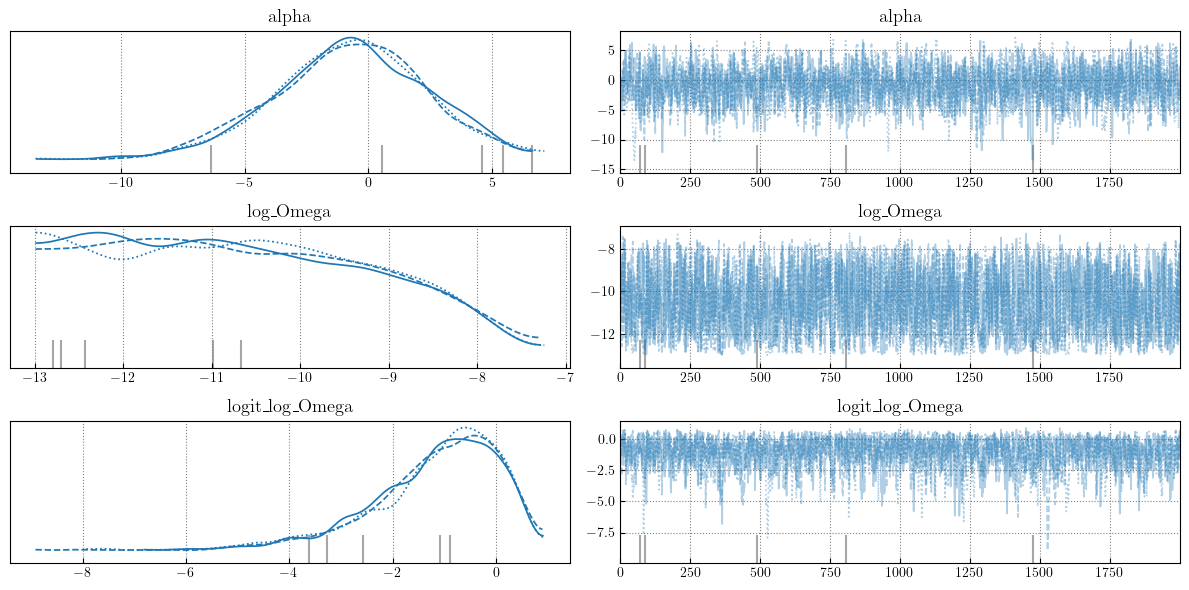

In [3]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

And a corner plot:

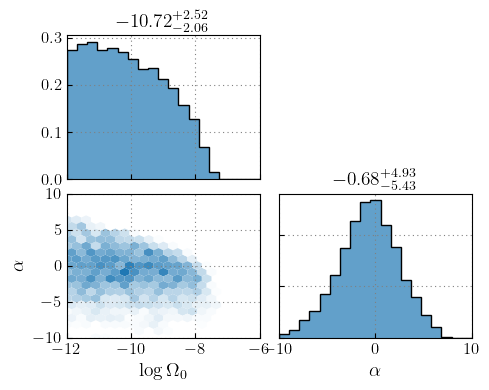

In [4]:
stacked_samples = data.posterior.stack(draws=("chain", "draw"))

fig = plt.figure(figsize=(5,4))
toPlot = {
    "Omg":{"data":stacked_samples.log_Omega,"plot_bounds":(-12,-6),"label":r"$\log\Omega_0$"},
    "alpha":{"data":stacked_samples.alpha,"plot_bounds":(-10,10),"label":r"$\alpha$"}
}
plot_corner(fig,toPlot,'#1f78b4')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

Double-check the sensibility of these results by plotting the implied posterior on $\Omega(f)$ as well as the anticipated Hanford-Livingston O3 PI curve: 

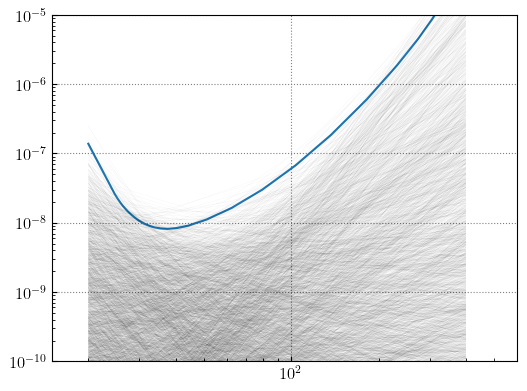

In [5]:
# Get HL O3 uncertainty spectrum
spectra = get_all_data()
freqs = spectra['H1L1_O3'][0]
sigmas = spectra['H1L1_O3'][2]

# Compute PI curve
pi = pi_curve(freqs,sigmas,-8,8)

# Instantiate figure and plot PI curve
fig,ax = plt.subplots()
ax.plot(freqs,pi)

# Loop across posterior samples, plotting each one
for i in range(stacked_samples.log_Omega.size):
    Omega_f = 10.**stacked_samples.log_Omega.values[i]*(freqs/25.)**stacked_samples.alpha.values[i]
    ax.plot(freqs,Omega_f,color='black',lw=0.1,alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(15,600)
ax.set_ylim(1e-10,1e-5)
plt.show()